## Definition of PasteAndOcclude

In [1]:
import random
import logging
import numpy as np
import sys
import copy
from fvcore.transforms.transform import (
    BlendTransform,
    CropTransform,
    HFlipTransform,
    NoOpTransform,
    Transform,
    VFlipTransform,
)
from PIL import Image

from detectron2.data.transforms.augmentation import Augmentation

__all__ = [
    "PasteAndOcclude",
]


# -*- coding: utf-8 -*-
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# Modified by Cheng-Yen Hsieh
import os
import logging
import numpy as np
import torch
import torch.nn.functional as F
from fvcore.transforms.transform import (
    CropTransform,
    HFlipTransform,
    NoOpTransform,
    Transform,
    TransformList,
)
from PIL import Image

try:
    import cv2  # noqa
except ImportError:
    # OpenCV is an optional dependency at the moment
    pass

__all__ = [
    "PasteAndOccludeTransform",
]


class PasteAndOccludeTransform(Transform):
    """
    """

    def __init__(self, scaled_h, scaled_w, offset_y, offset_x, img_scale, target_size, 
                 selected_segments,
                 segment_object_root,
                 interp=None):
        """
        Args:
            h, w (int): original image size
            new_h, new_w (int): new image size
            selected_segments: A list of dictionaries, where each dict contain the following keys:
                'image_path'
                'height'
                'width'
                'category_id'
                'x'
                'y'
            segment_object_root: Root path to segment object images.
            interp: PIL interpolation methods, defaults to bilinear.
        """
        # TODO decide on PIL vs opencv
        super().__init__()
        if interp is None:
            interp = Image.BILINEAR
        self._set_attributes(locals())

    def load_segment_object_img(self, segment) -> np.ndarray:
        """Load the images of segment object, resize it, and convert it into a np array
        """
        img_path = os.path.join(self.segment_object_root, segment['image_path'])
        pil_img = Image.open(img_path)

        pil_img = pil_img.resize((segment['width'], segment['height']), self.interp)
        ret = np.asarray(pil_img)  # (H, W, 3)
        return ret

    def update_segment_position(self, scaled_w, scaled_h, offset_x, offset_y):
        """Update the segmented object position based on scale and offset.

        If the scaled_w and scaled_h are changed manually, we need to regenerate the position of the object
        to avoid the object being completely out-of-frame.
        """
        for selected_segment in self.selected_segments:
            img_w = min(scaled_w, offset_x + self.target_size[1]) - offset_x
            img_h = min(scaled_h, offset_y + self.target_size[0]) - offset_y

            # Randomly decide the position of the object among the range
            min_x = 0 - selected_segment['width'] * (3 / 4)
            max_x = img_w - selected_segment['width'] * (1 / 4)

            min_y = 0 - selected_segment['height'] * (3 / 4)
            max_y = img_h - selected_segment['height'] * (1 / 4)
            x = np.random.uniform(min_x, max_x)
            y = np.random.uniform(min_y, max_y)

            selected_segment['x'] = int(x)
            selected_segment['y'] = int(y)
            
    def apply_image(self, img, interp=None):
        assert len(img.shape) <= 4

        if img.dtype == np.uint8:
            pil_image = Image.fromarray(img)
            interp_method = interp if interp is not None else self.interp
            pil_image = pil_image.resize((self.scaled_w, self.scaled_h), interp_method)
            ret = np.array(pil_image)
            right = min(self.scaled_w, self.offset_x + self.target_size[1])
            lower = min(self.scaled_h, self.offset_y + self.target_size[0])
            if len(ret.shape) <= 3:
                ret = ret[self.offset_y: lower, self.offset_x: right]
            else:
                ret = ret[..., self.offset_y: lower, self.offset_x: right, :]

        else:
            # PIL only supports uint8
            img = torch.from_numpy(img)
            shape = list(img.shape)
            shape_4d = shape[:2] + [1] * (4 - len(shape)) + shape[2:]
            img = img.view(shape_4d).permute(2, 3, 0, 1)  # hw(c) -> nchw
            _PIL_RESIZE_TO_INTERPOLATE_MODE = {Image.BILINEAR: "bilinear", Image.BICUBIC: "bicubic"}
            mode = _PIL_RESIZE_TO_INTERPOLATE_MODE[self.interp]
            img = F.interpolate(img, (self.scaled_h, self.scaled_w), mode=mode, align_corners=False)
            shape[:2] = (self.scaled_h, self.scaled_w)
            ret = img.permute(2, 3, 0, 1).view(shape).numpy()  # nchw -> hw(c)
            right = min(self.scaled_w, self.offset_x + self.target_size[1])
            lower = min(self.scaled_h, self.offset_y + self.target_size[0])
            if len(ret.shape) <= 3:
                ret = ret[self.offset_y: lower, self.offset_x: right]
            else:
                ret = ret[..., self.offset_y: lower, self.offset_x: right, :]
        
        # Apply PasteAndOcclude
        for selected_segment in self.selected_segments:
            object_img = self.load_segment_object_img(selected_segment)
            object_mask = object_img != 0
            x = selected_segment['x']
            y = selected_segment['y']
            w = selected_segment['width']
            h = selected_segment['height']
            object_offset_x = max(-x, 0)
            object_offset_y = max(-y, 0)

            if len(ret.shape) <= 3:
                img_h = ret.shape[0]
                img_w = ret.shape[1]
                
            else:
                img_h = ret.shape[-3]
                img_w = ret.shape[-2]

            object_offset_w = - max(x + w - img_w, 0)
            object_offset_h = - max(y + h - img_h, 0)
            min_y, min_x = max(y, 0), max(x, 0)


            if len(ret.shape) <= 3:
                object_mask = object_mask[object_offset_y: h + object_offset_h, 
                                                object_offset_x: w + object_offset_w]
                ret[min_y: y+h, min_x: x+w][object_mask] = object_img[object_offset_y: h + object_offset_h, 
                                                   object_offset_x: w + object_offset_w][object_mask]
            else:
                object_mask = object_mask[..., object_offset_y: h + object_offset_h, 
                                                object_offset_x: w + object_offset_w, :]
                ret[..., min_y: y+h, min_x: x+w, :][object_mask] = object_img[..., object_offset_y: h + object_offset_h, 
                                                   object_offset_x: w + object_offset_w, :][object_mask]
        return ret

    def apply_coords(self, coords):
        coords[:, 0] = coords[:, 0] * self.img_scale
        coords[:, 1] = coords[:, 1] * self.img_scale
        coords[:, 0] -= self.offset_x
        coords[:, 1] -= self.offset_y
        return coords

    def apply_segmentation(self, segmentation):
        segmentation = self.apply_image(segmentation, interp=Image.NEAREST)
        return segmentation

    def inverse(self):
        raise NotImplementedError
        
class PasteAndOcclude(Augmentation):
    """
    Scale the shorter edge to the given size, with a limit of `max_size` on the longer edge.
    If `max_size` is reached, then downscale so that the longer edge does not exceed max_size.

    Then, randomly select 0~num_segments segmented object from the list to apply paste and occlude.
    """

    def __init__(
        self, size, scale, segments, num_segments=2, interp=Image.BILINEAR, h=-1, w=-1,
        segment_object_scale=(0.2, 1.2),
        segment_object_size=256,
        segment_object_root='',
    ):
        """
        Args:
            size (int): e.g., 896
            scale (tuple): e.g., (0.8, 1.2)
            segments: A list of dictionaries
                Each dict contains information about the segmented object with the following keys:
                    - image_path
                    - height
                    - width
                    - category_id
                    - annotation_id
            num_segments(int):
                maximum number of segmentds pasted onto the image
        """
        super().__init__()
        if h < 0 and w < 0:
            self.target_size = (size, size)
        else:
            self.target_size = (h, w)
        self.scale = scale
        self.interp = interp
        self.segments = segments
        self.num_segments = num_segments

        self.segment_object_size = (segment_object_size, segment_object_size)
        self.segment_object_scale = segment_object_scale
        self.segment_object_root = segment_object_root
        logger = logging.getLogger(__name__)
        logger.info("PasteAndOcclude: Get {} segmented objects. "
                    "Maximum number of pasted objects: {}".format(len(segments), num_segments))

    def randomly_select_segments(self):
        """Randomly Select 0~num_segments objects from the segment set."""
        num_of_object = np.random.randint(1, self.num_segments + 1)
        self.selected_segments = np.random.choice(self.segments, size=num_of_object)
        self.selected_segments = copy.deepcopy(self.selected_segments)

    def get_transform(self, img):
        # Select a random scale factor.
        scale_factor = np.random.uniform(*self.scale)
        scaled_target_height = scale_factor * self.target_size[0]
        scaled_target_width = scale_factor * self.target_size[1]
        # Recompute the accurate scale_factor using rounded scaled image size.
        width, height = img.shape[1], img.shape[0]
        img_scale_y = scaled_target_height / height
        img_scale_x = scaled_target_width / width
        img_scale = min(img_scale_y, img_scale_x)

        # Select non-zero random offset (x, y) if scaled image is larger than target size
        scaled_h = int(height * img_scale)
        scaled_w = int(width * img_scale)
        offset_y = scaled_h - self.target_size[0]
        offset_x = scaled_w - self.target_size[1]
        offset_y = int(max(0.0, float(offset_y)) * np.random.uniform(0, 1))
        offset_x = int(max(0.0, float(offset_x)) * np.random.uniform(0, 1))

        # TODO: Randomly decide the position and size of the segment object
        # Send segment objects as list of dicts into transform
        selected_segments = copy.deepcopy(self.selected_segments)  # Deep copy to avoid interference between two transforms
        for selected_segment in selected_segments:
            # Randomly decide the size of the object
            object_scale_factor_h, object_scale_factor_w = np.random.uniform(*self.segment_object_scale, 2)
            scaled_object_height = int(object_scale_factor_h * self.segment_object_size[0])
            scaled_object_width = int(object_scale_factor_w * self.segment_object_size[1])

            selected_segment['height'] = scaled_object_height
            selected_segment['width'] = scaled_object_width

            # TODO: The problem now is img_w here is not what we actually use in Gen Image Motion
            # The width, height is (640, 480) at first and then will changed to (932, 896) 
            # As we call aug_input.apply_augmentations twice
            img_w = min(scaled_w, offset_x + self.target_size[1]) - offset_x
            img_h = min(scaled_h, offset_y + self.target_size[0]) - offset_y

            # Randomly decide the position of the object among the range
            min_x = 0 - scaled_object_width * (3 / 4)
            max_x = img_w - scaled_object_width * (1 / 4)

            min_y = 0 - scaled_object_height * (3 / 4)
            max_y = img_h - scaled_object_height * (1 / 4)
            x = np.random.uniform(min_x, max_x)
            y = np.random.uniform(min_y, max_y)

            selected_segment['x'] = int(x)
            selected_segment['y'] = int(y)

        return PasteAndOccludeTransform(
            scaled_h, scaled_w, offset_y, offset_x, img_scale, self.target_size, selected_segments,
            self.segment_object_root,
            self.interp)

/home/chengyeh/.conda/envs/TAO-Amodal-gtr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load TAO-Amodal-Segment-Object Dataset and Example Image

In [2]:
import json
with open('/compute/trinity-1-38/chengyeh/lvis/Segment-Object/segment_object.json', 'r') as f:
    segments = json.load(f)

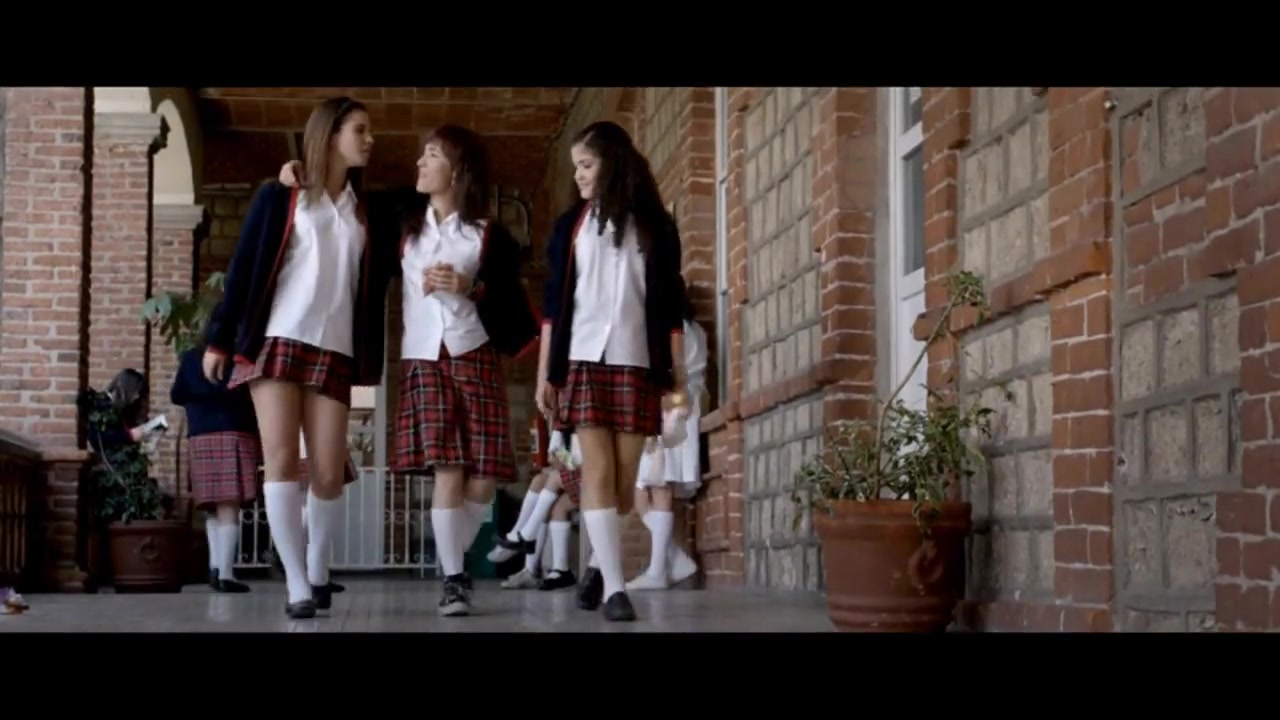

In [3]:
from PIL import Image
from IPython.display import display

img_path = '/data3/chengyeh/TAO/frames/test/ArgoVerse/side_right_7d37fc6b-1028-3f6f-b980-adb5fa73021e/ring_side_right_315968389405370400.jpg'
img_path = '/data3/chengyeh/TAO/frames/train/AVA/ZbeMNLwASVo_scene_8_105836-106782/frame0554.jpg'
img = Image.open(img_path)

display(img)

## Apply PasteAndOcclude on a Sequence of Synthetic Frames

(720, 1280, 3)
This object (x, y, width, height): (640, 394, 266, 61)
This object (x, y, width, height): (721, 26, 173, 239)
This object (x, y, width, height): (492, 107, 51, 283)
(W, H): (896, 532)


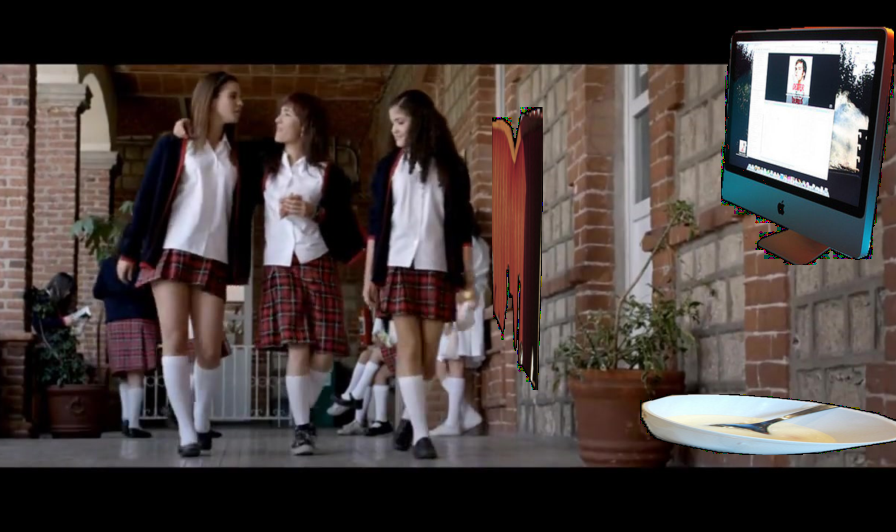

This object (x, y, width, height): (637, 307, 210, 137)
This object (x, y, width, height): (443, 79, 206, 197)
This object (x, y, width, height): (406, 213, 120, 254)
(W, H): (896, 572)


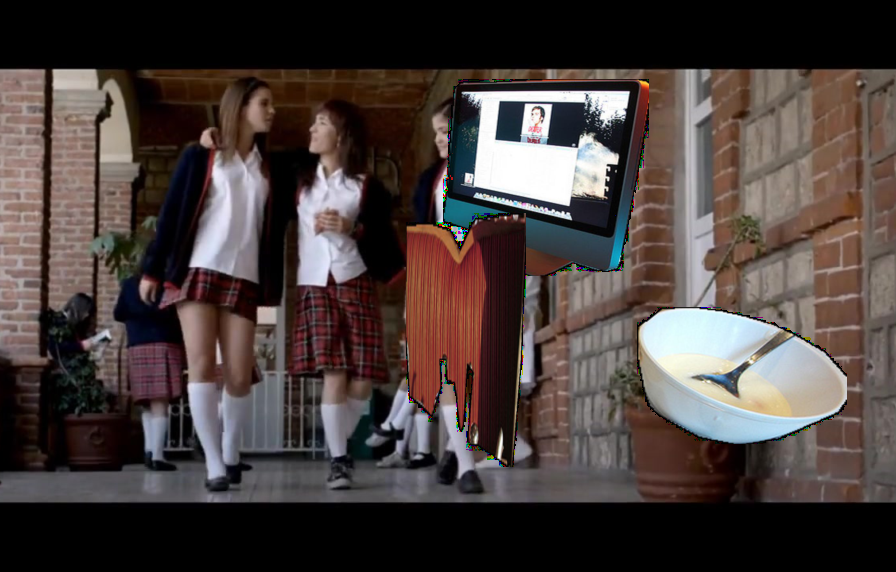

This object (x, y, width, height): (634, 221, 154, 213)
This object (x, y, width, height): (165, 132, 240, 156)
This object (x, y, width, height): (320, 320, 189, 226)
(W, H): (896, 613)


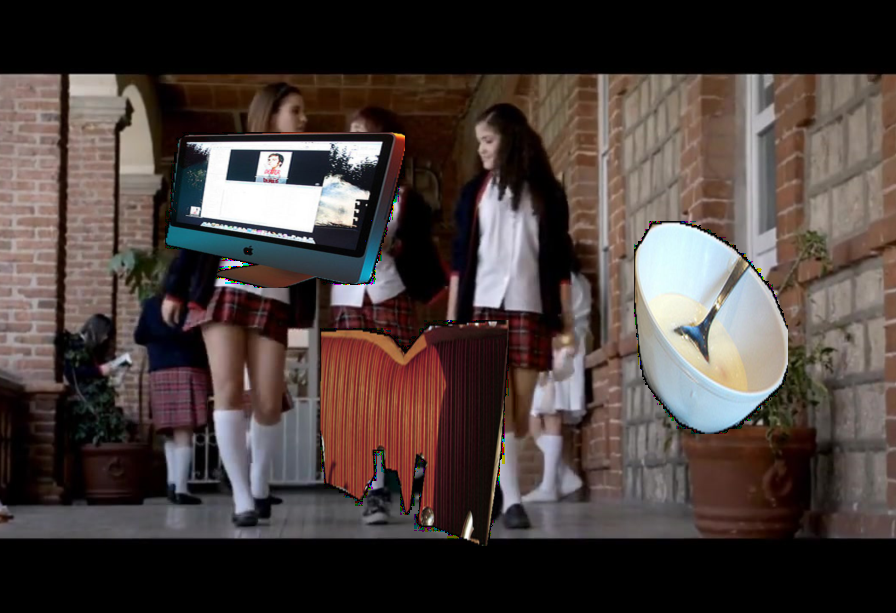

This object (x, y, width, height): (632, 135, 98, 289)
This object (x, y, width, height): (-113, 186, 274, 115)
This object (x, y, width, height): (235, 427, 258, 198)
(W, H): (896, 654)


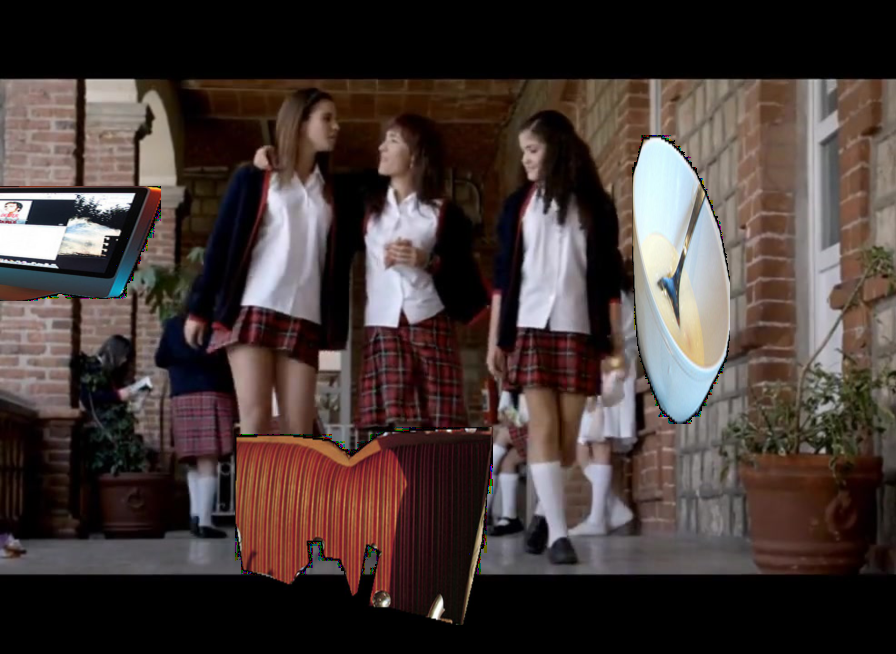

In [19]:
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
paste_and_occlude = PasteAndOcclude(size=896, num_segments=3, scale=(0.8, 1.2), segments=segments['segments'],
                segment_object_root='/compute/trinity-1-38/chengyeh/lvis/Segment-Object')

image = utils.read_image(img_path, format='RGB')
print(image.shape)

motion_augmentations = [paste_and_occlude]
np.random.seed(20)
motion_augmentations[0].randomly_select_segments()
aug_input = T.StandardAugInput(image)
aug_input2 = T.StandardAugInput(image)

transforms_st = aug_input.apply_augmentations(motion_augmentations)
transforms_ed = aug_input.apply_augmentations(motion_augmentations)
transforms_list = []
num_frames = 4
width, height = image.shape[1], image.shape[0]

# Update the position of segmented object in the last frame.
transforms_ed[0].update_segment_position(int(width * transforms_ed[0].img_scale), 
                                    int(height * transforms_ed[0].img_scale),
                                    transforms_ed[0].offset_x, 
                                    transforms_ed[0].offset_y) 
for x in range(num_frames):
    trans = copy.deepcopy(transforms_st)
    trans[0].offset_x += (transforms_ed[0].offset_x - \
        transforms_st[0].offset_x) * x // (num_frames - 1)
    trans[0].offset_y += (transforms_ed[0].offset_y - \
        transforms_st[0].offset_y) * x // (num_frames - 1)
    trans[0].img_scale += (transforms_ed[0].img_scale - \
        transforms_st[0].img_scale) * x / (num_frames - 1)
    trans[0].scaled_h = int(height * trans[0].img_scale)
    trans[0].scaled_w = int(width * trans[0].img_scale)
    for i, selected_segments in enumerate(trans[0].selected_segments):
        selected_segments['x'] += (transforms_ed[0].selected_segments[i]['x'] - \
        transforms_st[0].selected_segments[i]['x']) * x // (num_frames - 1)
        selected_segments['y'] += (transforms_ed[0].selected_segments[i]['y'] - \
        transforms_st[0].selected_segments[i]['y']) * x // (num_frames - 1)
        
        selected_segments['width'] += (transforms_ed[0].selected_segments[i]['width'] - \
        transforms_st[0].selected_segments[i]['width']) * x // (num_frames - 1)
        
        selected_segments['height'] += (transforms_ed[0].selected_segments[i]['height'] - \
        transforms_st[0].selected_segments[i]['height']) * x // (num_frames - 1)

        print("This object (x, y, width, height): ({}, {}, {}, {})".format( 
                                           selected_segments['x'],
                                           selected_segments['y'],
                                           selected_segments['width'],
                                           selected_segments['height']))
        
    new_image = trans.apply_image(image)
    print("(W, H): ({}, {})".format(new_image.shape[1], new_image.shape[0]))

    display(Image.fromarray(new_image))